In [1]:
import numpy as np
import pandas as pd
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, MaxPool2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
train = pd.read_csv("../input/digit-recognizer/train.csv")
test = pd.read_csv("../input/digit-recognizer/test.csv")

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
y_train = train['label']
X_train = train.drop('label', axis=1)
X_train.head()


In [5]:
#Make pixel values a max of 1
X_train = X_train/255
test = test/255

In [6]:
print(X_train.shape)
print(test.shape)

(42000, 784)
(28000, 784)


In [7]:
#covert each picture to 28x28 array to use CNN
X_train = X_train.values
test = test.values

In [8]:
X_train = X_train.reshape(-1,28,28,1)
test = test.reshape(-1,28,28,1)

print(X_train.shape)
print(test.shape)

(42000, 28, 28, 1)
(28000, 28, 28, 1)


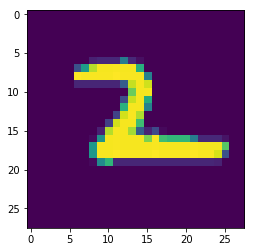

In [9]:
imshow(X_train[44][:,:,0])

In [10]:
#Make y values one hot encoded

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y.T

y_train = convert_to_one_hot(y_train.values, 10)
y_train.shape

(42000, 10)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state = 1, test_size = 0.05)


In [12]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.3))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(10, activation = "softmax"))

In [13]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer = optimizer,
              loss = "categorical_crossentropy", metrics=["accuracy"])

In [14]:
model.fit(x=X_train, y=y_train, epochs=5, batch_size=128)

Epoch 1/5
39900/39900 [==============================] - 118s 3ms/step - loss: 0.2576 - accuracy: 0.9161
Epoch 2/5
39900/39900 [==============================] - 116s 3ms/step - loss: 0.0677 - accuracy: 0.9794
Epoch 3/5
39900/39900 [==============================] - 118s 3ms/step - loss: 0.0528 - accuracy: 0.9842
Epoch 4/5
39900/39900 [==============================] - 120s 3ms/step - loss: 0.0419 - accuracy: 0.9866
Epoch 5/5
39900/39900 [==============================] - 119s 3ms/step - loss: 0.0373 - accuracy: 0.9883


In [15]:
# Save the model
model.save('RM_Digit_Recognizer_model.h5')

# Recreate the exact same model purely from the file
#new_model = keras.models.load_model('RM_Digit_Recognizer_model.h5')

In [16]:
predictions = model.predict_classes(X_val)

In [17]:
y_val = np.argmax(y_val, axis=1)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_val,predictions))
print(confusion_matrix(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       0.99      1.00      0.99       250
           2       0.97      0.98      0.98       234
           3       0.96      1.00      0.98       204
           4       1.00      0.97      0.98       207
           5       0.99      0.99      0.99       200
           6       1.00      0.99      0.99       186
           7       1.00      0.97      0.99       189
           8       1.00      0.99      1.00       205
           9       0.97      1.00      0.98       215

    accuracy                           0.99      2100
   macro avg       0.99      0.99      0.99      2100
weighted avg       0.99      0.99      0.99      2100

[[210   0   0   0   0   0   0   0   0   0]
 [  0 249   1   0   0   0   0   0   0   0]
 [  0   0 229   5   0   0   0   0   0   0]
 [  0   0   0 203   0   0   0   0   0   1]
 [  0   1   1   0 200   0   0   0   0   5]
 [  0   0   1   1   0 198 

In [19]:
predictions_test = model.predict_classes(test)

In [20]:
predictions_test = pd.DataFrame(predictions_test)
indices = pd.DataFrame(np.arange(1,len(predictions_test)+1))
predictions_submit = pd.concat([indices, predictions_test], axis = 1)
predictions_submit.columns = ['ImageId', 'Label']
predictions_submit.to_csv('submission.csv', index=False)